In [162]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy_groupies as npg
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import tomotopy as tt

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [163]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/figure5'

In [164]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [165]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [166]:
def go_plot(table, n_top=25, filename=None):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, (1, 3))
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.round(np.linspace(0, top['adj_p_val'].max(), 4), 2), rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.linspace(0, n_genes.max(), 4),
        np.round(np.linspace(0, n_genes.max(), 4), 2),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

# Oligodendrocytes

In [323]:
k = 15
model = tt.LDAModel.load(f'/proj/human_adult/20220222/harmony/analysis/LDA/oligodendrocytes/{k}/model.bin')
cells = np.loadtxt(f'/proj/human_adult/20220222/harmony/analysis/LDA/oligodendrocytes/{k}/cells.txt').astype('int')
transformed = np.vstack([doc.get_topic_dist() for doc in model.docs])
transformed.shape

(200000, 15)

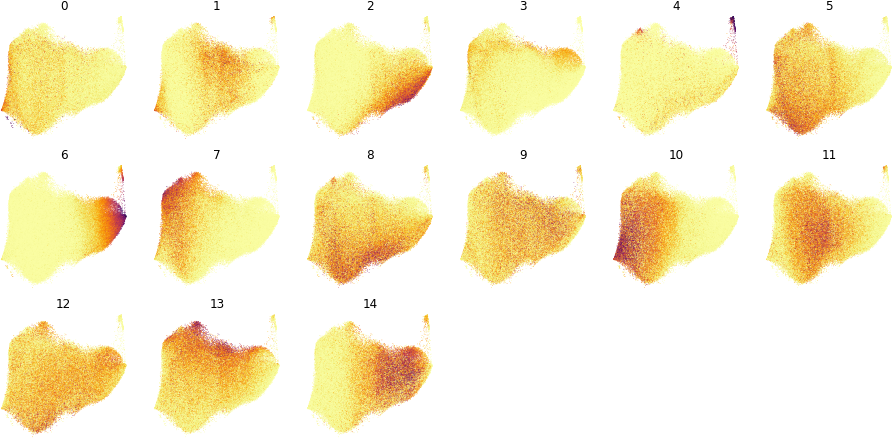

In [325]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:

    plt.figure(None, (16, 16))
    gs = plt.GridSpec(6, 6)

    xy = ds.ca.TSNE[cells]
    
    for i in range(k):
        plt.subplot(gs[i])
        plt.scatter(xy[:, 0], xy[:, 1], c=transformed[:, i], s=0.5, lw=0, rasterized=True, cmap='inferno_r')
        plt.axis('off')
        plt.title(i)
        plt.margins(0.01, 0.01)

In [326]:
topics = np.vstack([model.get_topic_word_dist(i, normalize=False) for i in range(k)])
total_per_gene = topics.sum(axis=0)
normed_topics = topics / total_per_gene

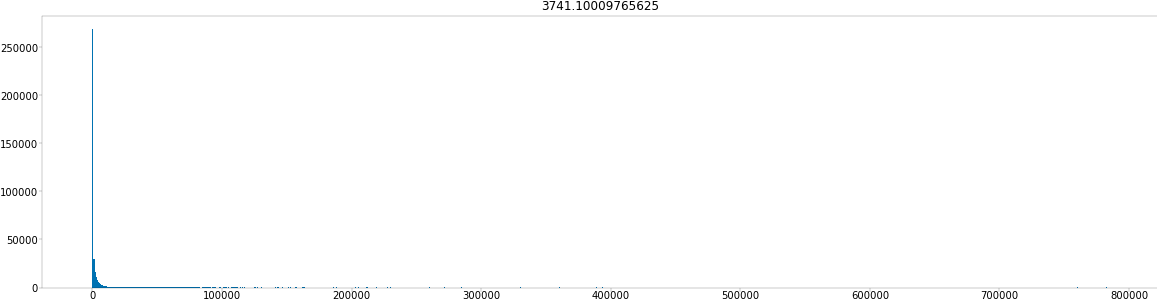

In [327]:
plt.figure(None, (20, 5))
plt.hist(topics.flatten(), bins=1000)
plt.title(np.percentile(topics.flatten(), 90))
plt.show()

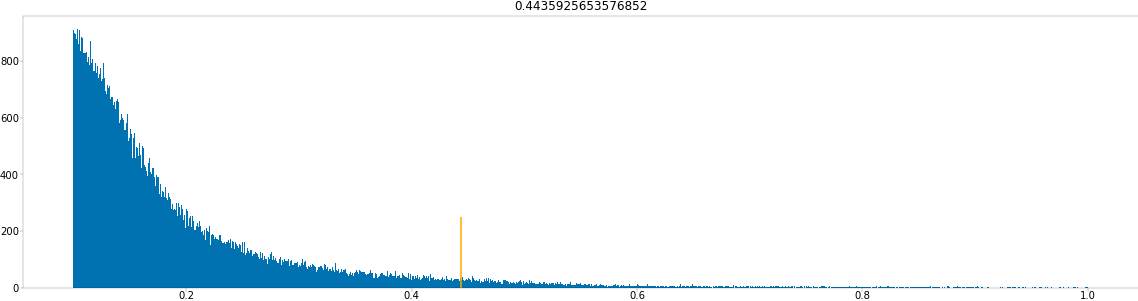

In [332]:
plt.figure(None, (20, 5))
plt.hist(normed_topics.flatten(), bins=1000, range=(0.1, 1))
plt.vlines(np.percentile(normed_topics.flatten(), 99), 0, 250, color='orange')
plt.title(np.percentile(normed_topics.flatten(), 99))
plt.show()

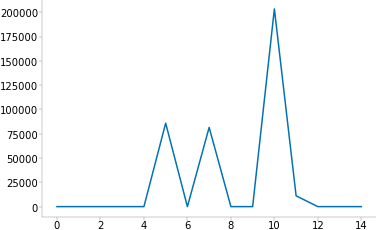

In [387]:
g = 'OPALIN'

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:

    ix_dict = dict(zip(ds.ra.Accession, np.arange(ds.shape[0])))
    ix = np.array([ix_dict.get(x) for x in list(model.vocabs)])
    plt.plot(topics[:, ds.ra.Gene[ix] == g])

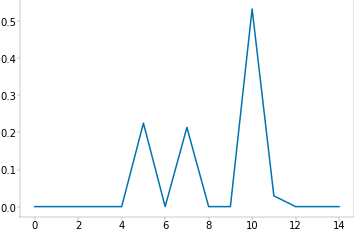

In [388]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:

    ix_dict = dict(zip(ds.ra.Accession, np.arange(ds.shape[0])))
    ix = np.array([ix_dict.get(x) for x in list(model.vocabs)])
    plt.plot(normed_topics[:, ds.ra.Gene[ix] == g])

In [460]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:

    k = topics.shape[0]
    accessions = ds.ra.Accession
    accession_dict = dict(zip(accessions, range(ds.shape[0]))) 
    
    filtered_top_genes = {}
    for n in range(k):
        # only keep genes that are > 100 and > 0.7 normed
        selected = (normed_topics[n] > 0.5) & (topics[n] > 10000) 
        print(selected.sum())
        filtered_topics = topics[n, selected]
        ix = np.array([accession_dict.get(x) for x in list(model.vocabs)])
        filtered_genes = ds.ra.Gene[ix][selected]
        filtered_top_genes[n] = filtered_genes[filtered_topics.argsort()[::-1]]

20
1
5
13
3
18
44
7
15
1
30
0
0
10
10



### TOPIC 0 ###



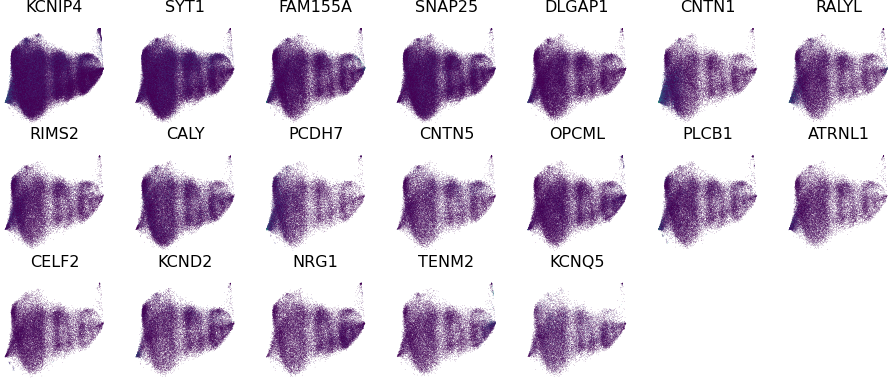


### TOPIC 1 ###



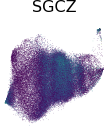


### TOPIC 2 ###



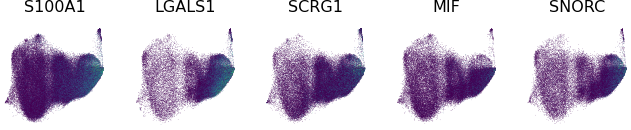


### TOPIC 3 ###



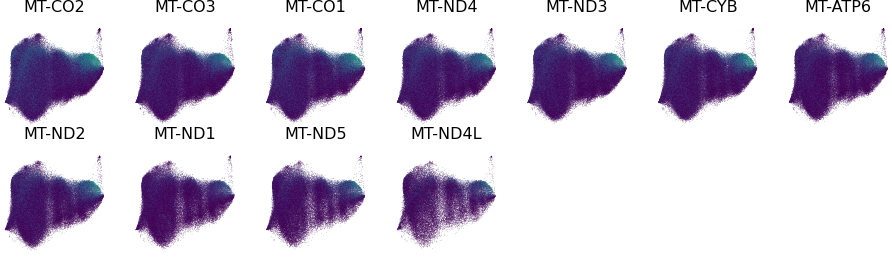


### TOPIC 4 ###



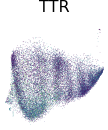


### TOPIC 5 ###



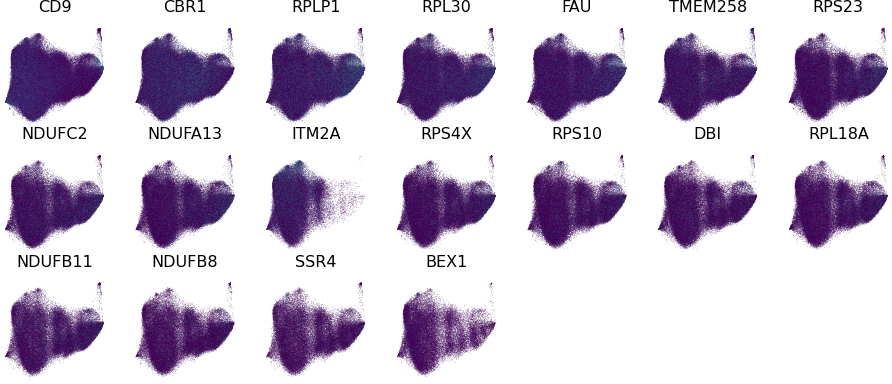


### TOPIC 6 ###



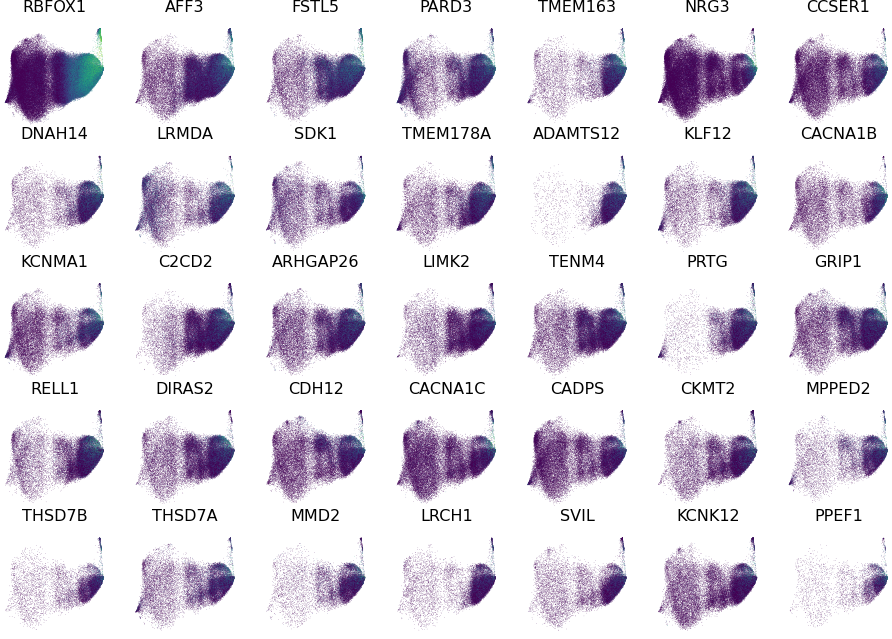


### TOPIC 7 ###



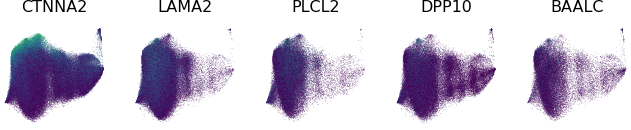


### TOPIC 8 ###



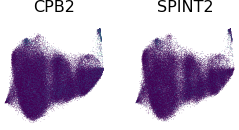


### TOPIC 9 ###



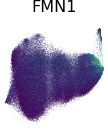


### TOPIC 10 ###



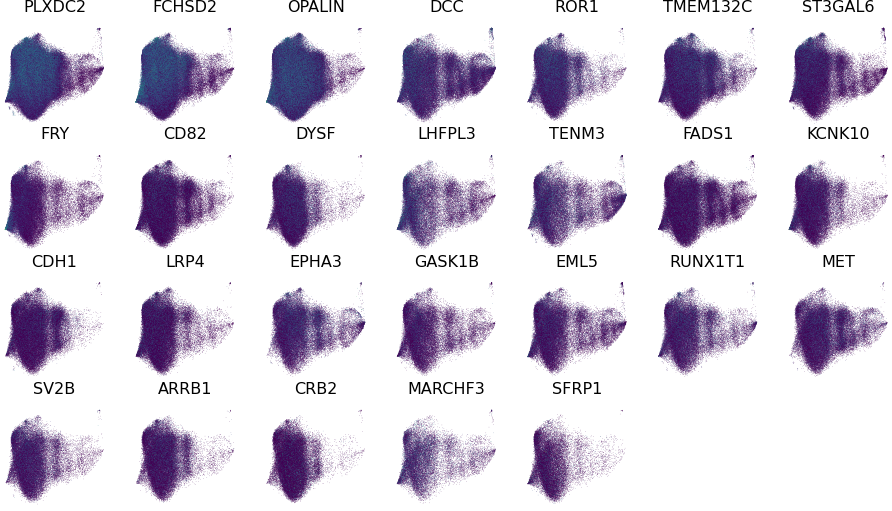


### TOPIC 11 ###



<Figure size 1152x1152 with 0 Axes>


### TOPIC 12 ###



<Figure size 1152x1152 with 0 Axes>


### TOPIC 13 ###



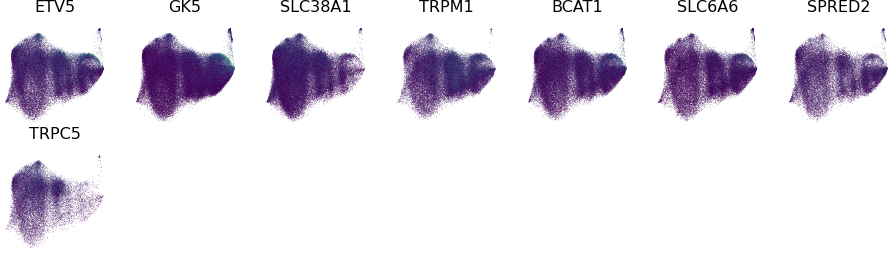


### TOPIC 14 ###



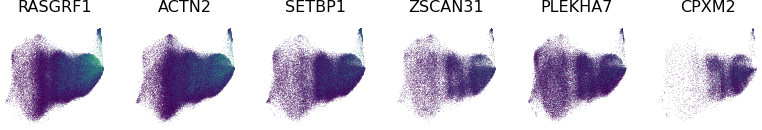

In [374]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:

    for n in range(k):
        
        print(f'\n### TOPIC {n} ###\n')
    
        plt.figure(None, (8, 8), dpi=144, facecolor='white')
        gs = plt.GridSpec(7, 7)
    
        nc = pd.Series(filtered_top_genes[n][:49]).isin(ncRNA_genes).to_numpy()
        to_plot = filtered_top_genes[n][:49][~nc]

        for i, g in enumerate(to_plot):
            plt.subplot(gs[i])
            exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
            exp_cells = exp > 0
            plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=0.05, lw=0, rasterized=True)
            plt.scatter(ds.ca.TSNE[exp_cells, 0], ds.ca.TSNE[exp_cells, 1], c=exp[exp_cells], s=0.05, lw=0, rasterized=True)
            plt.axis('off')
            plt.title(g, fontsize=8)
            plt.margins(0.05, 0.05)
            
        plt.show()

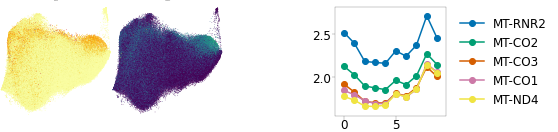

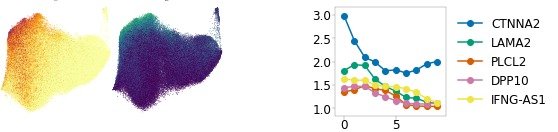

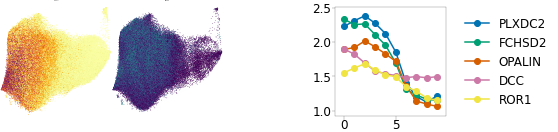

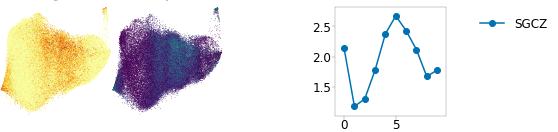

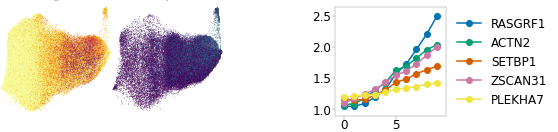

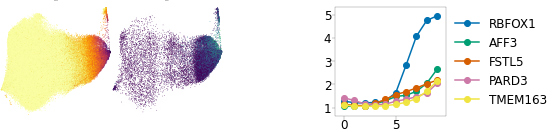

In [418]:
from scipy.stats import binned_statistic

selected_topics = [3, 7, 10, 1, 14, 6]
selected_genes = ['MT-CO2', 'CTNNA2', 'PLXDC2', 'SGCZ', 'SETBP1', 'TMEM163']

for i in range(len(selected_topics)):
               
    n = selected_topics[i]
    specific_gene = selected_genes[i]

    with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:

        plt.figure(None, (12, 2))
        gs = plt.GridSpec(1, 6)

        # scatter plot of topic values
        plt.subplot(gs[0])
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=transformed[:, n], s=0.5, lw=0, rasterized=True, cmap='inferno_r')
        plt.axis('off')
        plt.title(f'Topic {n}', fontsize=1)
        plt.margins(0.01, 0.01)

        # remove nc genes
        nc = pd.Series(filtered_top_genes[n]).str.startswith(('AC0','AC1','LINC', 'AL5', 'C5orf')).to_numpy()
        to_plot = filtered_top_genes[n][~nc][:5]
        
        # plot top gene
        plt.subplot(gs[1])        
        exp = np.log2(ds[np.where(ds.ra.Gene == specific_gene)[0][0], :].flatten() + 1)
        exp_cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=0.4, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[exp_cells, 0], ds.ca.TSNE[exp_cells, 1], c=exp[exp_cells], s=0.4, lw=0, rasterized=True, cmap='viridis')
        plt.axis('off')
        plt.title(g, fontsize=0.5)
        plt.margins(0.01, 0.01)

        # # empty subplot
        # plt.subplot(gs[2])
        # plt.axis('off')
        
        # plot genes binned along the x (maturation) axis 
        ax = plt.subplot(gs[3])
        for g in to_plot:
            exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
            # exclude MN cells
            exp_cells = (exp > 0) & (ds.ca.Clusters != 0)
            smthd, _, _ = binned_statistic(ds.ca.TSNE[exp_cells, 0], exp[exp_cells], statistic='mean', bins=10)
            plt.plot(smthd, marker='o', label=g)
        plt.yticks(fontsize=12)
        # plt.ylabel('Mean expression', fontsize=11)
        plt.xticks(fontsize=12)
        # plt.xlabel('Position along x-axis', fontsize=11)
        # ax.axis["left"].set_visible(False)
        # ax.axis["top"].set_visible(False)
        plt.margins(0.1, 0.1)
               
        # make legend
        handles, labels = ax.get_legend_handles_labels()
        ax = plt.subplot(gs[4])
        ax.legend(handles, labels, frameon=False, fontsize=12)    
        plt.axis('off')
               
        plt.subplots_adjust(wspace=0, hspace=0)
        
        plt.savefig(f'/home/kimberly/figures/figure5/topic{n}.pdf', dpi=300)

# Infer topics from pre-trained model

In [419]:
homologues = pd.read_csv('../202110/homologues.txt', delimiter='\t').dropna()
homologues.head()

Gene stable ID Mouse gene stable ID Mouse gene name Gene name
0  ENSG00000198888   ENSMUSG00000064341          mt-Nd1    MT-ND1
1  ENSG00000198763   ENSMUSG00000064345          mt-Nd2    MT-ND2
2  ENSG00000198804   ENSMUSG00000064351          mt-Co1    MT-CO1
3  ENSG00000198712   ENSMUSG00000064354          mt-Co2    MT-CO2
4  ENSG00000228253   ENSMUSG00000064356         mt-Atp8   MT-ATP8

In [420]:
human_to_mouse = dict(zip(homologues['Gene stable ID'], homologues['Mouse gene stable ID']))
mouse_to_human = dict(zip(homologues['Mouse gene stable ID'], homologues['Gene stable ID']))

In [421]:
%%time

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    mouse_selected = np.where(ds.ra.Valid == 1)[0]
    mouse_accessions = np.array([mouse_to_human.get(x, '') for x in ds.ra.Accession[mouse_selected]])
    mouse_data = ds[mouse_selected, :]

CPU times: user 1min 48s, sys: 2.67 s, total: 1min 51s
Wall time: 1min 51s


In [422]:
converter = dict(zip(pd.Series(np.array(model.vocabs)).str.split('.').str[0].to_numpy(), model.vocabs))

In [423]:
mouse_accessions = np.array([converter.get(x, '') for x in mouse_accessions])
mouse_accessions

array(['ENSG00000150551.11', '', '', ..., 'ENSG00000048392.12',
       'ENSG00000178761.15', 'ENSG00000114853.14'], dtype='<U24')

In [ ]:
%%time 


corpus = tt.utils.Corpus()
[
    corpus.add_doc(
        list(np.repeat(mouse_accessions, mouse_data[:, i].astype('int').T, axis=0))
    ) 
    for i in range(mouse_data.shape[1])
]

In [425]:
mouse_transformed = model.infer(corpus, together=False)[0]

In [426]:
mouse_transformed = np.vstack([doc.get_topic_dist() for doc in mouse_transformed])
mouse_transformed.shape

(31073, 15)

In [427]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    print(np.unique(ds.ca.ClusterName))

['COP1' 'COP2' 'MFOL1' 'MFOL2' 'MOL1' 'MOL2' 'MOL3' 'NFOL1' 'NFOL2' 'OPC']


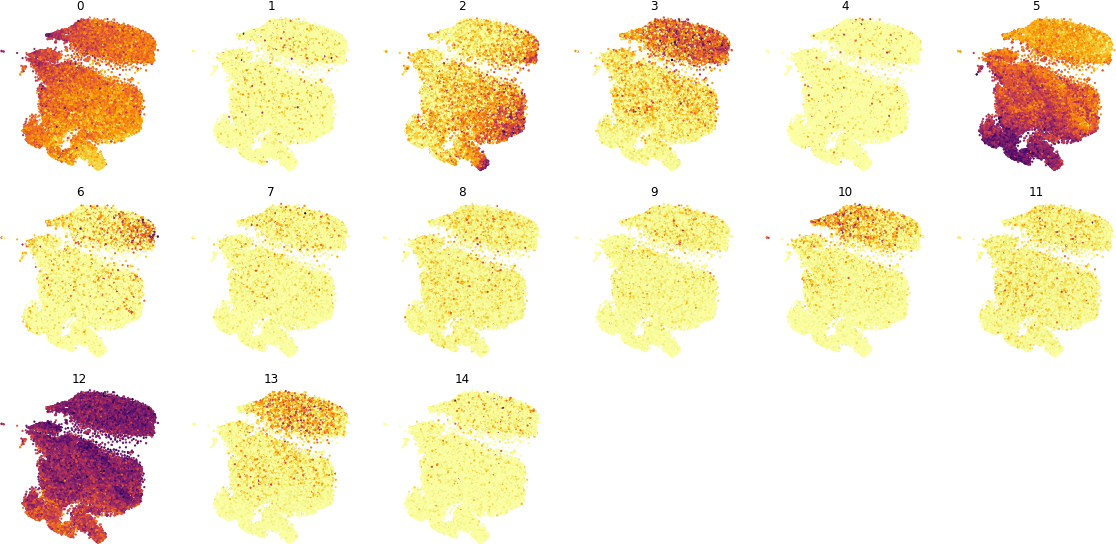

In [432]:
plt.figure(None, (20, 20))
gs = plt.GridSpec(6, 6)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    for i in range(k):
        ax = plt.subplot(gs[i])
        mature_oligos = pd.Series(ds.ca.ClusterName).str.contains('MOL|MFOL', regex=True)
        plt.scatter(ds.ca.TSNE[mature_oligos, 0], ds.ca.TSNE[mature_oligos, 1], c=mouse_transformed[mature_oligos, i], s=5, lw=0, cmap='inferno_r', rasterized=True)
        plt.axis('off')
        plt.title(i)
        plt.margins(0.01, 0.01)
        ax.invert_xaxis()
plt.show()

In [433]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:

    k = topics.shape[0]
    accessions = ds.ra.Accession
    accession_dict = dict(zip(accessions, range(ds.shape[0]))) 
    
    filtered_top_genes = {}
    for n in range(k):
        # only keep genes that are > 100 and > 0.7 normed
        selected = (normed_topics[n] > 0.4) & (topics[n] > 2000) 
        print(selected.sum())
        filtered_topics = topics[n, selected]
        ix = np.array([accession_dict.get(x) for x in list(model.vocabs)])
        filtered_genes = ds.ra.Gene[ix][selected]
        filtered_top_genes[n] = filtered_genes[filtered_topics.argsort()[::-1]]

185
3
27
16
21
216
188
25
378
5
117
23
12
27
50


In [436]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    topic6 = mouse_transformed[mature_oligos, 6]
    corr = np.array(
        [np.corrcoef(topic6, ds[i, :][mature_oligos])[0, 1] for i in range(ds.shape[0])]
    )

/proj/user/kimberly/miniconda3/envs/tomotopy/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/proj/user/kimberly/miniconda3/envs/tomotopy/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [437]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    top_corr = ds.ra.Gene[np.argsort(corr)[::-1]]
    top_corr = top_corr[~np.isnan(np.sort(corr)[::-1])]
top_corr[:20]

array(['Ugt8a', 'Scd2', 'Dpysl2', 'Secisbp2l', 'Elovl5', 'Sema5a',
       'Chst2', 'Qk', 'Kif1b', 'Plekhg1', 'mt-Co1', 'Hmgcs1', 'Mob3b',
       'Sept2', 'Magt1', 'Reep3', 'Fmnl2', 'Cpd', 'Elovl7', 'Kcnj10'],
      dtype=object)

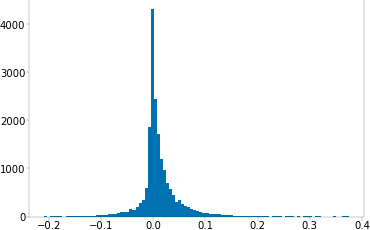

In [439]:
plt.hist(np.sort(corr), bins=100)
plt.show()

In [440]:
np.percentile(corr[~np.isnan(corr)], 90)

0.05077351433701402

In [441]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    mouse_topic6_genes = ds.ra.Gene[corr > 0.05]
mouse_topic6_genes[:100]

array(['Frmd4a', 'Pdcd4', 'Marcks', 'Cnksr3', 'Fam107b', '1810041L15Rik',
       'Rras2', 'Cntn1', 'Arap2', 'Nkain1', 'Rabgap1l', 'Igf2bp3',
       'Rpl35a', 'Il1rap', 'Samd4', 'Nfia', 'Atp5g2', 'Kansl1', 'Hapln2',
       'Nkx2-9', 'Rab37', '2700046A07Rik', 'Sepp1', 'Anxa5', 'Hopx',
       'Pmp22', 'Vat1l', 'Spry2', 'Dpysl5', 'Mob3b', 'Ncs1', 'Lmo7',
       'Maob', 'Nid1', 'Gm43207', 'Rasgrp3', 'Ttr', '1700025G04Rik',
       'Fndc3a', 'Ttc28', 'Ccdc88a', 'Mmp15', 'Gramd4', 'Qser1', 'Dner',
       'Pdzrn4', 'Sfpq', 'Cdc7', 'Tmem55a', 'Arl6ip1', 'Basp1', 'Whsc1',
       'Zfp41', 'Cntrl', 'Aak1', 'Opa3', 'Kbtbd11', 'Sobp', 'Ncapd2',
       'Cdk5rap2', 'Stag1', 'Spry1', 'Gnaz', 'Hnrnpul1', 'Ttc3', 'Helz',
       'Npas3', 'Nova1', 'Galnt10', 'Rad21', 'Zbtb20', 'Alcam', 'Sfxn1',
       'Scel', 'Epn2', 'Syn2', 'Slc38a3', 'Tnpo1', 'Cbx5', 'Prrc2a',
       'Nucks1', 'Raph1', 'Zmat3', 'Pkia', 'Mapk7', 'Cav1', 'Fry',
       'Elavl4', 'Celf2', 'Cpe', 'Mmp2', 'Dcx', 'Nrxn2', 'Snx10', 'Lbh',
       

In [444]:
human_to_mouse = dict(zip(homologues['Gene name'], homologues['Mouse gene name']))
common_genes = list(set(mouse_topic6_genes).intersection([human_to_mouse.get(x, '') for x in filtered_top_genes[6]]))
len(common_genes)

47

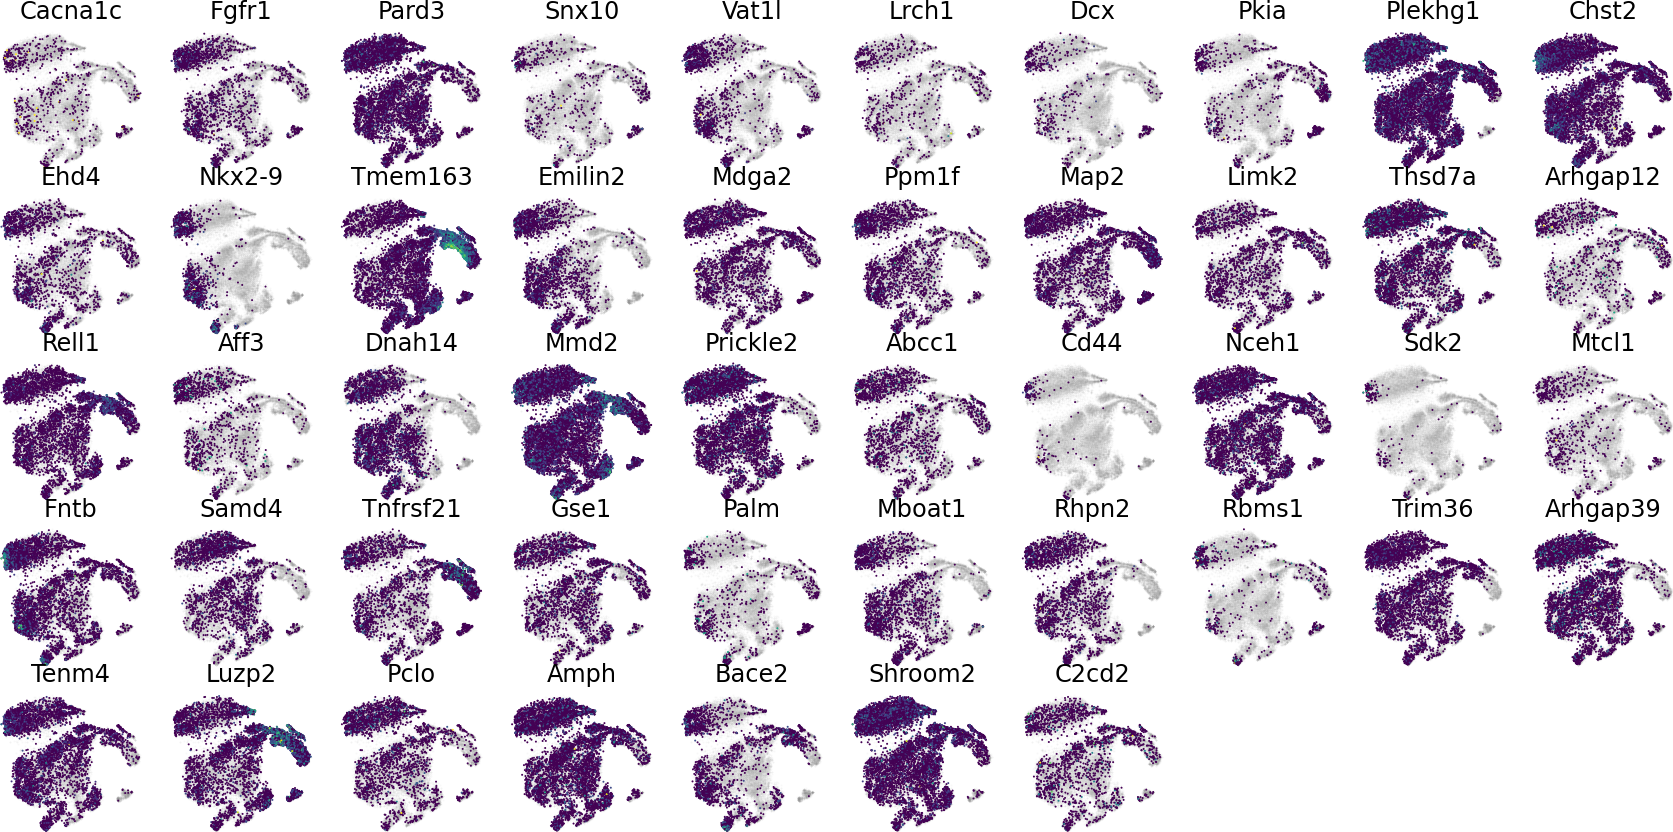

In [446]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
        
    plt.figure(None, (15, 15), dpi=144)
    gs = plt.GridSpec(10, 10)

    to_plot = common_genes

    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True, cmap='viridis')
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='viridis')
        plt.axis('off')
        plt.title(g)
        plt.margins(0.01, 0.01)

    plt.show()

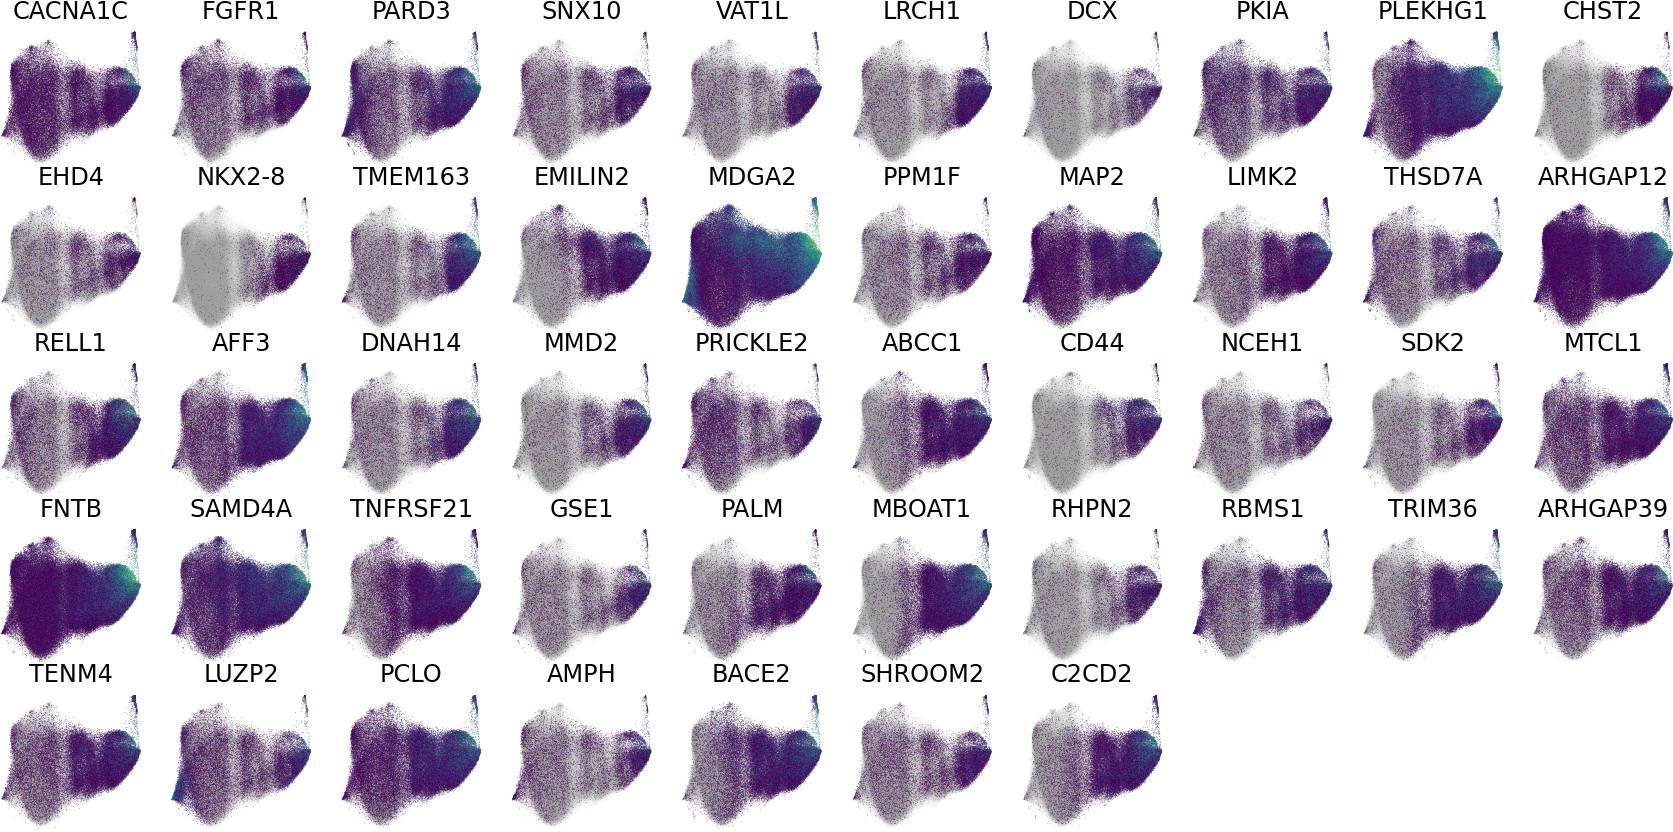

In [449]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:
        
    plt.figure(None, (15, 15), dpi=144)
    gs = plt.GridSpec(10, 10)

    mouse_to_human = dict(zip(homologues['Mouse gene name'], homologues['Gene name']))
    to_plot = set(mouse_topic6_genes).intersection([human_to_mouse.get(x, '') for x in filtered_top_genes[6]])
    to_plot = [mouse_to_human.get(x, '') for x in to_plot]

    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=0.1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=0.1, lw=0, rasterized=True)
        plt.axis('off')
        plt.title(g)
        plt.margins(0.01, 0.01)

    plt.show()

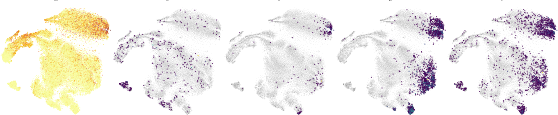

In [456]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    
    plt.figure(None, (10, 2))
    gs = plt.GridSpec(1, 5)

    n = 6
    
    ax = plt.subplot(gs[0])
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=mouse_transformed[:, n], s=0.5, lw=0, rasterized=True, cmap='inferno_r')
    plt.axis('off')
    plt.title(f'Topic {n}', fontsize=0.5)
    plt.margins(0.01, 0.01)
    ax.invert_xaxis()
    
    to_plot = ['Rbfox1', 'Cd44', 'Nkx2-9', 'Vat1l']

    for i, g in enumerate(to_plot):
        ax = plt.subplot(gs[i + 1])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        exp_cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[exp_cells, 0], ds.ca.TSNE[exp_cells, 1], c=exp[exp_cells], s=1, lw=0, rasterized=True, cmap='viridis')
        plt.axis('off')
        plt.title(g, fontsize=0.5)
        plt.margins(0.01, 0.01)
        ax.invert_xaxis()
        
        plt.subplots_adjust(wspace=0, hspace=0)
        
    plt.savefig(f'/home/kimberly/figures/figure5/topic{n}_mouse.pdf', dpi=300)

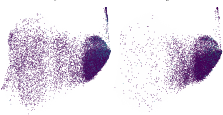

In [457]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligodendrocytes.loom', 'r') as ds:
    
    plt.figure(None, (10, 2))
    gs = plt.GridSpec(1, 5)

    n = 6
    
    to_plot = ['VAT1L', 'NKX2-8']

    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        exp_cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=0.4, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[exp_cells, 0], ds.ca.TSNE[exp_cells, 1], c=exp[exp_cells], s=0.4, lw=0, rasterized=True, cmap='viridis')
        plt.axis('off')
        plt.title(g, fontsize=0.5)
        plt.margins(0.01, 0.01)
    
    plt.subplots_adjust(wspace=0, hspace=0)
        
    plt.savefig(f'/home/kimberly/figures/figure5/topic{n}_human.pdf', dpi=300)